**Context**

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using   hashtag   based   supervision   but   such   datasets   are   noisy   in   terms   of   labels   and language.  Furthermore,  many  tweets  are  replies  to  other  tweets  and  detecting  sarcasm  in these  requires  the  availability  of  contextual  tweets.In  this  hands-on  project,  the  goal  is  to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs

**Data**

The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets:Since  news  headlines  are  written  by  professionals  in  a  formal  manner,  there  are  no  spelling  mistakes  and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.Furthermore,  since  the  sole  purpose  of  TheOnion  is  to  publish  sarcastic  news,  we  get  high-quality  labels  with much less noise as compared to Twitter datasets.Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elementsContent: Each record consists of three attributes:is_sarcastic: 1 if the record is sarcastic otherwise 0headline: the headline of the news articlearticle_link: link to the original news article. Useful in collecting supplementary data     Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

**Objective**

Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.

In [13]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.5.0'

Read and explore the data

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [15]:
location = '/content/drive/MyDrive/Data for NLP /Sarcasm_Headlines_Dataset.json'

Loading the data from JSON File and doing Analysis

In [16]:
import pandas as pd
data = pd.read_json(location, lines = True)
data.head()

article_link  ... is_sarcastic
0  https://www.huffingtonpost.com/entry/versace-b...  ...            0
1  https://www.huffingtonpost.com/entry/roseanne-...  ...            0
2  https://local.theonion.com/mom-starting-to-fea...  ...            1
3  https://politics.theonion.com/boehner-just-wan...  ...            1
4  https://www.huffingtonpost.com/entry/jk-rowlin...  ...            0

[5 rows x 3 columns]

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [18]:
data.isnull().sum() # Checking for null values 

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [19]:
data.is_sarcastic.value_counts() #checking for target column counts

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [20]:
df = data.is_sarcastic.value_counts().to_frame()

In [21]:
df = df.reset_index()

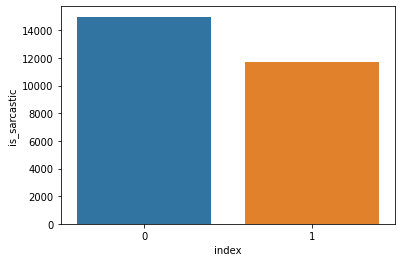

In [22]:
import seaborn as sns
sns.barplot(data=df,x=df['index'],y=df["is_sarcastic"])

Seperating Sarcastic and Non Sarcastic sets

In [23]:
sarcastic_headlines = data.loc[data['is_sarcastic'] == 1]
#undersample non sarcastic headline
non_sarcastic_headlines = data.loc[data['is_sarcastic'] == 0]

Retain relevant columns

In [24]:
# Dropping "article_link" from both sets
sarcastic_headlines = sarcastic_headlines.drop(columns="article_link",axis = 1)
non_sarcastic_headlines = non_sarcastic_headlines.drop(columns="article_link",axis = 1)

Get length of each sentence

In [25]:
df = pd.concat([sarcastic_headlines, non_sarcastic_headlines])

In [26]:
df.head()

headline  is_sarcastic
2   mom starting to fear son's web series closest ...             1
3   boehner just wants wife to listen, not come up...             1
8   top snake handler leaves sinking huckabee camp...             1
15  nuclear bomb detonates during rehearsal for 's...             1
16  cosby lawyer asks why accusers didn't come for...             1

In [27]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [28]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [29]:
import nltk
nltk.download('stopwords')

# Clean the headlines
import re
from nltk.corpus import stopwords 
from pickle import dump, load

clean_balanced_headlines = []
for headline in df['headline']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = False))
print('Data is cleaned!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Data is cleaned!


In [30]:
df['cleaned_headline'] = clean_balanced_headlines
df.head()

headline  ...                                   cleaned_headline
2   mom starting to fear son's web series closest ...  ...  mom starting to fear son s web series closest ...
3   boehner just wants wife to listen, not come up...  ...  boehner just wants wife to listen  not come up...
8   top snake handler leaves sinking huckabee camp...  ...  top snake handler leaves sinking huckabee camp...
15  nuclear bomb detonates during rehearsal for 's...  ...  nuclear bomb detonates during rehearsal for  s...
16  cosby lawyer asks why accusers didn't come for...  ...  cosby lawyer asks why accusers did not come fo...

[5 rows x 3 columns]

Observation: 
The data has been processed and cleaned

In [31]:
data = df.drop('headline', axis = 1)
data.head()

is_sarcastic                                   cleaned_headline
2              1  mom starting to fear son s web series closest ...
3              1  boehner just wants wife to listen  not come up...
8              1  top snake handler leaves sinking huckabee camp...
15             1  nuclear bomb detonates during rehearsal for  s...
16             1  cosby lawyer asks why accusers did not come fo...

In [32]:
data['sentence_length'] = data['cleaned_headline'].str.len()

In [33]:
rows,columns = data.shape


In [34]:
rows

26709

In [35]:
data.head()

is_sarcastic  ... sentence_length
2              1  ...              79
3              1  ...              84
8              1  ...              50
15             1  ...              64
16             1  ...              89

[5 rows x 3 columns]

In [36]:
data['word_count'] = 0

In [37]:
for row in range(0,rows):
  data["word_count"][row] = len(data['cleaned_headline'][row].split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
data.head()

is_sarcastic  ... word_count
2              1  ...         15
3              1  ...         14
8              1  ...          7
15             1  ...          9
16             1  ...         17

[5 rows x 4 columns]

Observation: 

*   The word length and the string lengths ahev been calculated



Model Development

Importing Necessary Libraries 

In [39]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

Setting Model Parameters

In [40]:
max_features = 10000
maxlen = data["word_count"].max()
embedding_size = 300

Applying tokenizers for the data set

In [41]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(data['cleaned_headline'])

Seperating the feature and the target attributes

In [42]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  128  859    1
  837  231    4 2116  592 4690  215   74   34   40    1]
Number of Labels:  26709
1


In [43]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  25374


Loading the Glove file ( Glove Embeddings ) 

In [44]:
glove = '/content/drive/MyDrive/Data for NLP /glove.6B.300d.txt'

In [45]:
embeddings = {}
for o in open(glove):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

Creating Weight Matrix

In [46]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

Model Creation

In [47]:
### create the model
model = Sequential()

### Embedding layer for hint 
model.add(Embedding(vocab_size, embedding_size, weights = [embedding_matrix]))

### Bidirectional LSTM layer for hint 
model.add(Bidirectional(LSTM(512, return_sequences = True)))

### dense
model.add(Dense(256, activation = 'relu'))

##dropout
model.add(Dropout(0.5, input_shape = (256,)))

##sigmoid
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         7612200   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1024)        3330048   
_________________________________________________________________
dense (Dense)                (None, None, 256)         262400    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           257       
Total params: 11,204,905
Trainable params: 11,204,905
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(X, y, batch_size = 32, epochs = 20, verbose = 1, validation_split = 0.2)

Epoch 1/20
668/668 [==============================] - 50s 66ms/step - loss: 0.4156 - accuracy: 0.8142 - val_loss: 0.3310 - val_accuracy: 0.8756
Epoch 2/20
668/668 [==============================] - 42s 64ms/step - loss: 0.2391 - accuracy: 0.9062 - val_loss: 0.2942 - val_accuracy: 0.8766
Epoch 3/20
668/668 [==============================] - 42s 63ms/step - loss: 0.1444 - accuracy: 0.9480 - val_loss: 0.3766 - val_accuracy: 0.8651
Epoch 4/20
668/668 [==============================] - 42s 63ms/step - loss: 0.0839 - accuracy: 0.9702 - val_loss: 0.5412 - val_accuracy: 0.8344
Epoch 5/20
668/668 [==============================] - 42s 62ms/step - loss: 0.0531 - accuracy: 0.9821 - val_loss: 0.8138 - val_accuracy: 0.8281
Epoch 6/20
668/668 [==============================] - 42s 63ms/step - loss: 0.0317 - accuracy: 0.9896 - val_loss: 0.7686 - val_accuracy: 0.8587
Epoch 7/20
668/668 [==============================] - 42s 63ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.9713 - val_accuracy:

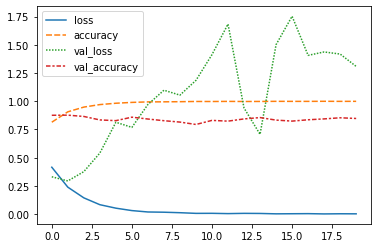

In [50]:
import seaborn as sns
sns.lineplot(data=history.history)

Observations & Conclusions

*   The data was loaded, processing done for model development
*   The text data was cleaned up for model development
*   The glove embeddings were loaded from file
*   based on the validation loss, the model has been run for more epochs than needed - The model has over fit
*   Did not run the model again, becasue the model took a long time to run, but in real life scenarios, would have run it again
*   The various project objective have been completed







